# PAVD Profile Visualization

This notebook visualizes the outputs from `scripts/batch_pavd_profiles.py`, including:
- Summary statistics across all scan positions
- Detailed vertical Plant Area Volume Density (PAVD) profiles
- Comparison of different estimation methods (Hinge, Linear, Weighted)
- Plant Area Index (PAI) and Mean Leaf Angle (MLA) profiles

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set output directory
OUTPUT_DIR = Path('../pavd_output')

## Load Data

In [3]:
# Load summary data
summary_df = pd.read_csv(OUTPUT_DIR / 'pavd_summary.csv')

print(f"Loaded summary data for {len(summary_df)} scan positions")
print(f"\nSummary columns: {summary_df.columns.tolist()}")
summary_df.head()

Loaded summary data for 64 scan positions

Summary columns: ['scan_pos', 'scan_name', 'sensor_x', 'sensor_y', 'sensor_z', 'ground_intercept', 'ground_slope_x', 'ground_slope_y', 'total_pai_hinge', 'total_pai_linear', 'total_pai_weighted']


,scan_pos,scan_name,sensor_x,sensor_y,sensor_z,ground_intercept,ground_slope_x,ground_slope_y,total_pai_hinge,total_pai_linear,total_pai_weighted
0,ScanPos001,210727_072658,-0.280429,-0.243502,-0.444524,-2.264972,-0.003283,-0.004351,17.622169,16.764462,17.641272
1,ScanPos002,210727_073047,19.415365,-0.673438,-0.456548,-2.222951,-0.004369,-0.004747,17.491272,14.066894,17.376796
2,ScanPos003,210727_073357,39.017550,-0.395079,-0.583120,-2.229707,-0.004618,-0.004984,13.905214,13.132120,14.063894
3,ScanPos004,210727_073747,59.215572,-0.459530,-0.668471,-2.271942,-0.003778,-0.005488,10.874529,9.371714,11.124885
4,ScanPos005,210727_074119,79.020680,-1.094299,-0.817143,-2.281470,-0.003972,-0.004765,15.798113,11.971663,15.597020


In [4]:
# Load all profile files
profile_files = sorted(OUTPUT_DIR.glob('ScanPos*_profiles.csv'))
print(f"Found {len(profile_files)} profile files")

# Load first profile as example
if profile_files:
    example_profile = pd.read_csv(profile_files[0])
    print(f"\nProfile columns: {example_profile.columns.tolist()}")
    print(f"Height range: {example_profile['height'].min():.1f} - {example_profile['height'].max():.1f} m")
    print(f"Number of height bins: {len(example_profile)}")

Found 64 profile files

Profile columns: ['height', 'hinge_pai', 'linear_pai', 'weighted_pai', 'hinge_pavd', 'linear_pavd', 'weighted_pavd', 'linear_mla']
Height range: 0.0 - 49.5 m
Number of height bins: 100


## Summary Visualizations

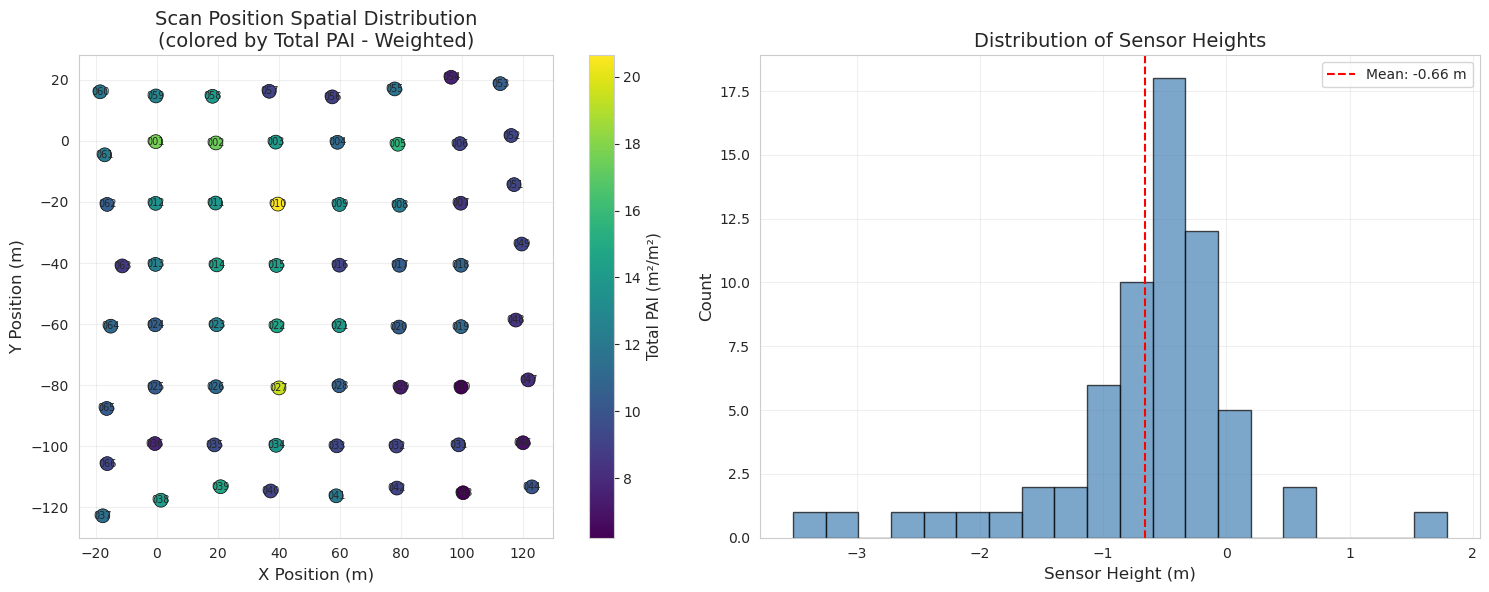

In [5]:
# Plot spatial distribution of scan positions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 2D scatter plot colored by total PAI
scatter = ax1.scatter(summary_df['sensor_x'], summary_df['sensor_y'], 
                      c=summary_df['total_pai_weighted'], 
                      s=100, cmap='viridis', edgecolors='black', linewidth=0.5)
ax1.set_xlabel('X Position (m)', fontsize=12)
ax1.set_ylabel('Y Position (m)', fontsize=12)
ax1.set_title('Scan Position Spatial Distribution\n(colored by Total PAI - Weighted)', fontsize=14)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Total PAI (m²/m²)', fontsize=11)

# Add scan position labels
for idx, row in summary_df.iterrows():
    ax1.annotate(row['scan_pos'].replace('ScanPos', ''), 
                (row['sensor_x'], row['sensor_y']),
                fontsize=7, ha='center', va='center')

# Histogram of sensor heights
ax2.hist(summary_df['sensor_z'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax2.set_xlabel('Sensor Height (m)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Sensor Heights', fontsize=14)
ax2.axvline(summary_df['sensor_z'].mean(), color='red', linestyle='--', 
           label=f"Mean: {summary_df['sensor_z'].mean():.2f} m")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

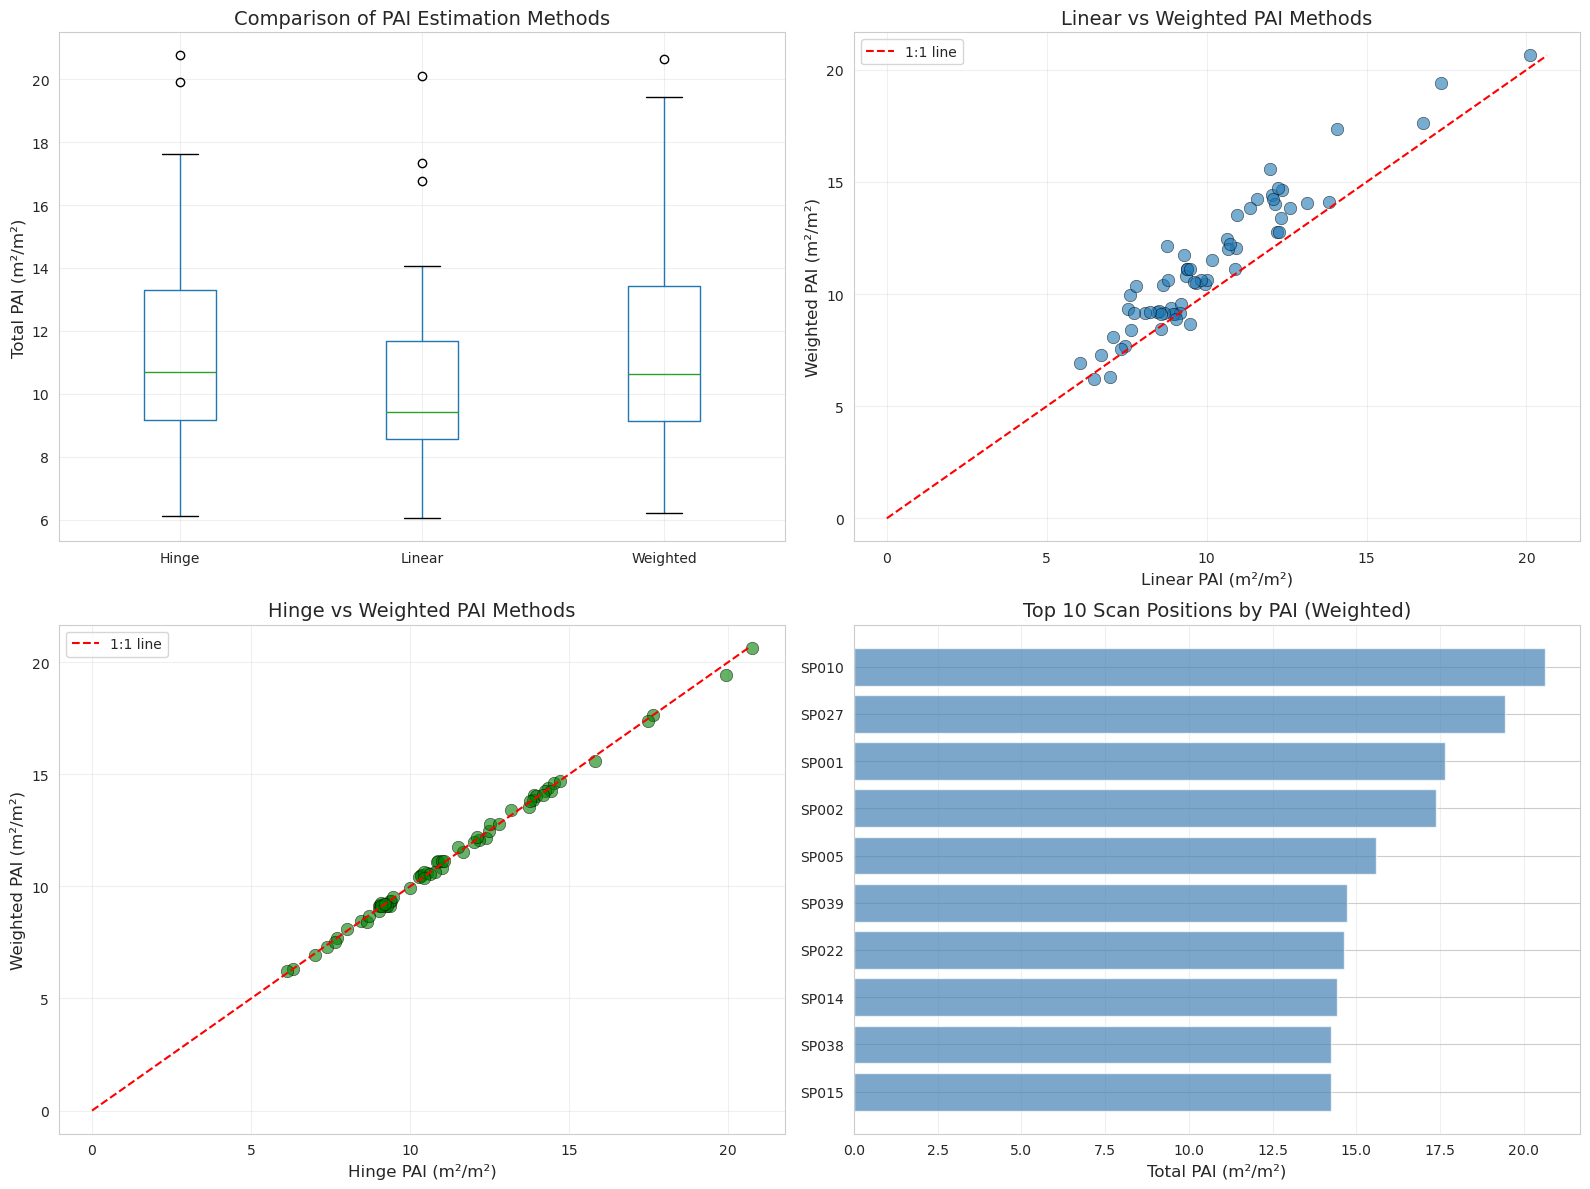

In [6]:
# Compare PAI estimation methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot comparing methods
pai_data = summary_df[['total_pai_hinge', 'total_pai_linear', 'total_pai_weighted']]
pai_data.columns = ['Hinge', 'Linear', 'Weighted']
pai_data.boxplot(ax=axes[0, 0])
axes[0, 0].set_ylabel('Total PAI (m²/m²)', fontsize=12)
axes[0, 0].set_title('Comparison of PAI Estimation Methods', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot: Linear vs Weighted
axes[0, 1].scatter(summary_df['total_pai_linear'], summary_df['total_pai_weighted'], 
                   alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
axes[0, 1].plot([0, summary_df['total_pai_weighted'].max()], 
                [0, summary_df['total_pai_weighted'].max()], 
                'r--', label='1:1 line')
axes[0, 1].set_xlabel('Linear PAI (m²/m²)', fontsize=12)
axes[0, 1].set_ylabel('Weighted PAI (m²/m²)', fontsize=12)
axes[0, 1].set_title('Linear vs Weighted PAI Methods', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot: Hinge vs Weighted  
axes[1, 0].scatter(summary_df['total_pai_hinge'], summary_df['total_pai_weighted'], 
                   alpha=0.6, s=80, edgecolors='black', linewidth=0.5, color='green')
axes[1, 0].plot([0, summary_df['total_pai_weighted'].max()], 
                [0, summary_df['total_pai_weighted'].max()], 
                'r--', label='1:1 line')
axes[1, 0].set_xlabel('Hinge PAI (m²/m²)', fontsize=12)
axes[1, 0].set_ylabel('Weighted PAI (m²/m²)', fontsize=12)
axes[1, 0].set_title('Hinge vs Weighted PAI Methods', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bar plot of top 10 scan positions by PAI
top_10 = summary_df.nlargest(10, 'total_pai_weighted').sort_values('total_pai_weighted')
y_pos = np.arange(len(top_10))
axes[1, 1].barh(y_pos, top_10['total_pai_weighted'], alpha=0.7, color='steelblue')
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(top_10['scan_pos'].str.replace('ScanPos', 'SP'))
axes[1, 1].set_xlabel('Total PAI (m²/m²)', fontsize=12)
axes[1, 1].set_title('Top 10 Scan Positions by PAI (Weighted)', fontsize=14)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

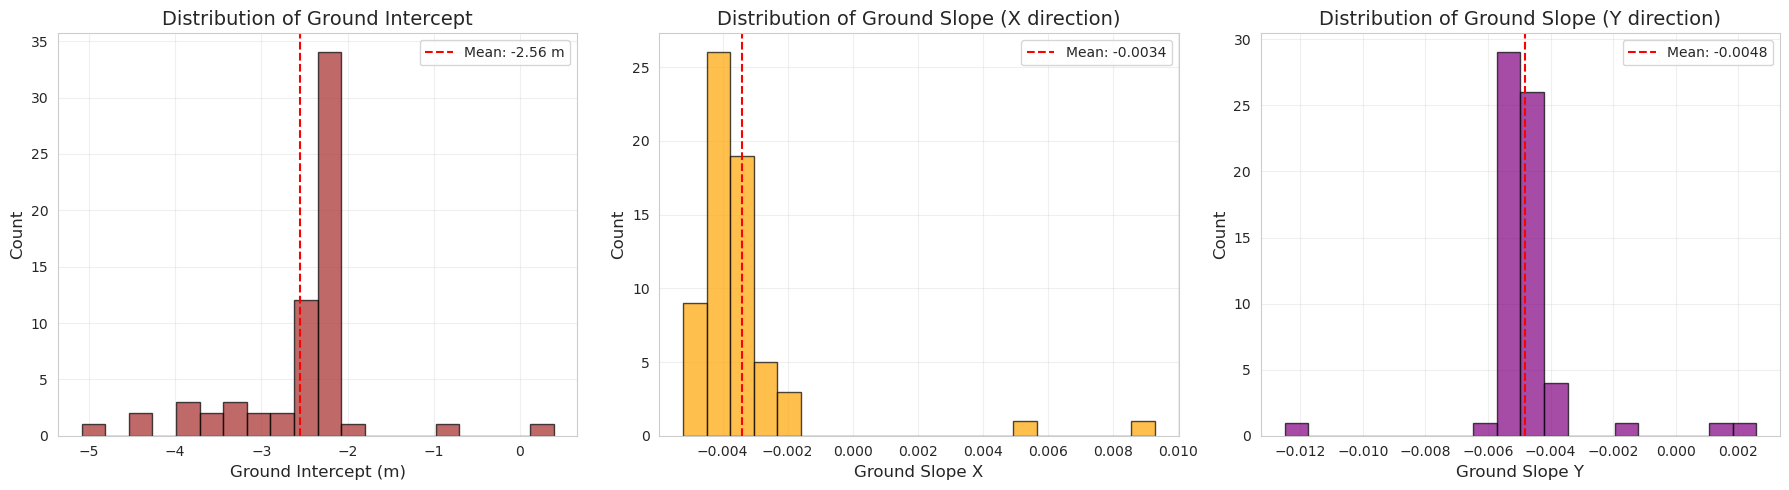

In [7]:
# Ground plane analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ground intercept histogram
axes[0].hist(summary_df['ground_intercept'], bins=20, edgecolor='black', alpha=0.7, color='brown')
axes[0].set_xlabel('Ground Intercept (m)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Ground Intercept', fontsize=14)
axes[0].axvline(summary_df['ground_intercept'].mean(), color='red', linestyle='--',
               label=f"Mean: {summary_df['ground_intercept'].mean():.2f} m")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Ground slope X
axes[1].hist(summary_df['ground_slope_x'], bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Ground Slope X', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Ground Slope (X direction)', fontsize=14)
axes[1].axvline(summary_df['ground_slope_x'].mean(), color='red', linestyle='--',
               label=f"Mean: {summary_df['ground_slope_x'].mean():.4f}")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Ground slope Y
axes[2].hist(summary_df['ground_slope_y'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[2].set_xlabel('Ground Slope Y', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Distribution of Ground Slope (Y direction)', fontsize=14)
axes[2].axvline(summary_df['ground_slope_y'].mean(), color='red', linestyle='--',
               label=f"Mean: {summary_df['ground_slope_y'].mean():.4f}")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Individual Profile Visualizations

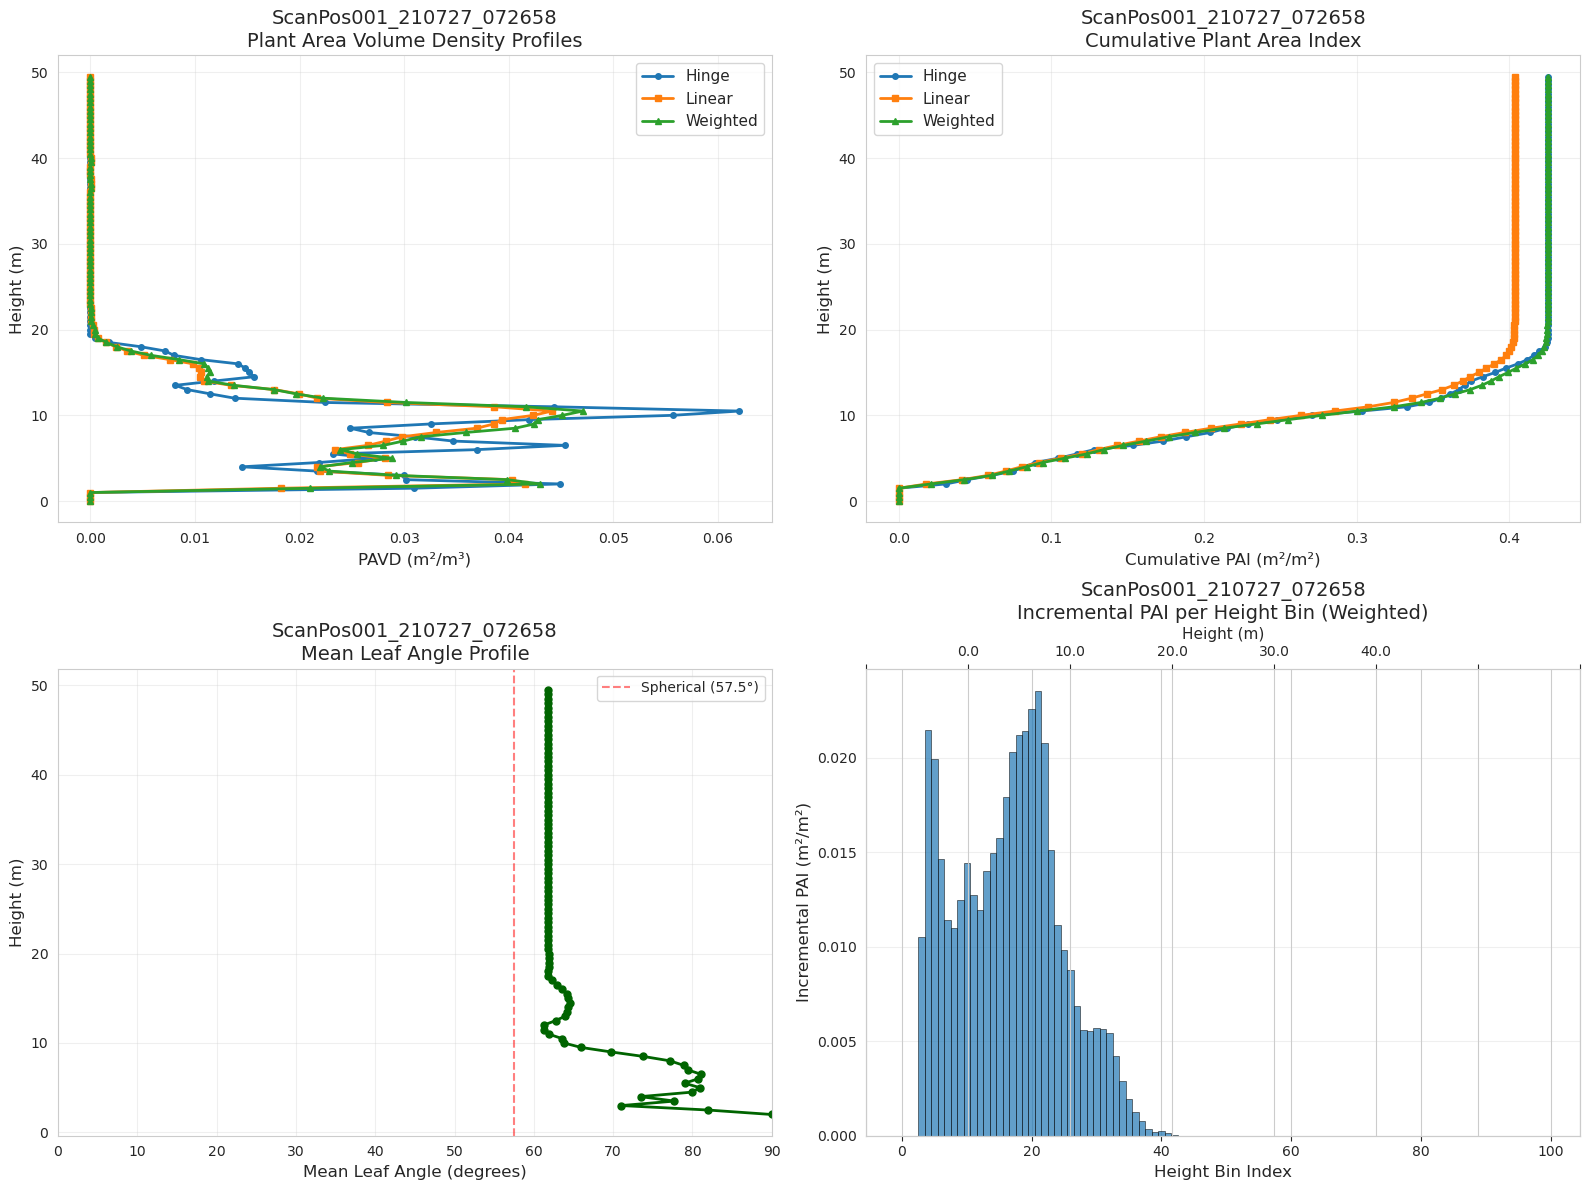

In [8]:
# Visualize a single scan position profile in detail
def plot_single_profile(profile_file, scan_pos_name):
    """Plot detailed profiles for a single scan position."""
    df = pd.read_csv(profile_file)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # PAVD profiles comparison
    axes[0, 0].plot(df['hinge_pavd'], df['height'], 'o-', label='Hinge', linewidth=2, markersize=4)
    axes[0, 0].plot(df['linear_pavd'], df['height'], 's-', label='Linear', linewidth=2, markersize=4)
    axes[0, 0].plot(df['weighted_pavd'], df['height'], '^-', label='Weighted', linewidth=2, markersize=4)
    axes[0, 0].set_xlabel('PAVD (m²/m³)', fontsize=12)
    axes[0, 0].set_ylabel('Height (m)', fontsize=12)
    axes[0, 0].set_title(f'{scan_pos_name}\nPlant Area Volume Density Profiles', fontsize=14)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # PAI profiles comparison
    axes[0, 1].plot(df['hinge_pai'], df['height'], 'o-', label='Hinge', linewidth=2, markersize=4)
    axes[0, 1].plot(df['linear_pai'], df['height'], 's-', label='Linear', linewidth=2, markersize=4)
    axes[0, 1].plot(df['weighted_pai'], df['height'], '^-', label='Weighted', linewidth=2, markersize=4)
    axes[0, 1].set_xlabel('Cumulative PAI (m²/m²)', fontsize=12)
    axes[0, 1].set_ylabel('Height (m)', fontsize=12)
    axes[0, 1].set_title(f'{scan_pos_name}\nCumulative Plant Area Index', fontsize=14)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Mean Leaf Angle profile
    # Filter out zeros for better visualization
    mla_df = df[df['linear_mla'] > 0].copy()
    axes[1, 0].plot(mla_df['linear_mla'], mla_df['height'], 'o-', 
                   color='darkgreen', linewidth=2, markersize=5)
    axes[1, 0].set_xlabel('Mean Leaf Angle (degrees)', fontsize=12)
    axes[1, 0].set_ylabel('Height (m)', fontsize=12)
    axes[1, 0].set_title(f'{scan_pos_name}\nMean Leaf Angle Profile', fontsize=14)
    axes[1, 0].set_xlim([0, 90])
    axes[1, 0].axvline(57.5, color='red', linestyle='--', alpha=0.5, label='Spherical (57.5°)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Incremental PAI (PAVD * height_resolution)
    hres = df['height'].diff().median()  # Get height resolution
    axes[1, 1].bar(df.index, df['weighted_pavd'] * hres, 
                  width=1.0, alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[1, 1].set_xlabel('Height Bin Index', fontsize=12)
    axes[1, 1].set_ylabel('Incremental PAI (m²/m²)', fontsize=12)
    axes[1, 1].set_title(f'{scan_pos_name}\nIncremental PAI per Height Bin (Weighted)', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add second x-axis with actual heights
    ax2 = axes[1, 1].twiny()
    ax2.set_xlim(axes[1, 1].get_xlim())
    ax2.set_xticks(axes[1, 1].get_xticks())
    ax2.set_xticklabels([f"{df.loc[int(x), 'height']:.1f}" if 0 <= x < len(df) else "" 
                        for x in axes[1, 1].get_xticks()])
    ax2.set_xlabel('Height (m)', fontsize=11)
    
    plt.tight_layout()
    plt.show()

# Plot first scan position
if profile_files:
    first_profile = profile_files[0]
    scan_name = first_profile.stem.replace('_profiles', '')
    plot_single_profile(first_profile, scan_name)

In [ ]:
# Interactive profile selector
from ipywidgets import interact, Dropdown

# Create dropdown options
profile_options = {f.stem.replace('_profiles', ''): f for f in profile_files}

@interact(scan_position=Dropdown(options=sorted(profile_options.keys()), 
                                 description='Scan Position:'))
def show_profile(scan_position):
    plot_single_profile(profile_options[scan_position], scan_position)

interactive(children=(Dropdown(description='Scan Position:', options=('ScanPos001_210727_072658', 'ScanPos002_…

## Multi-Profile Comparisons

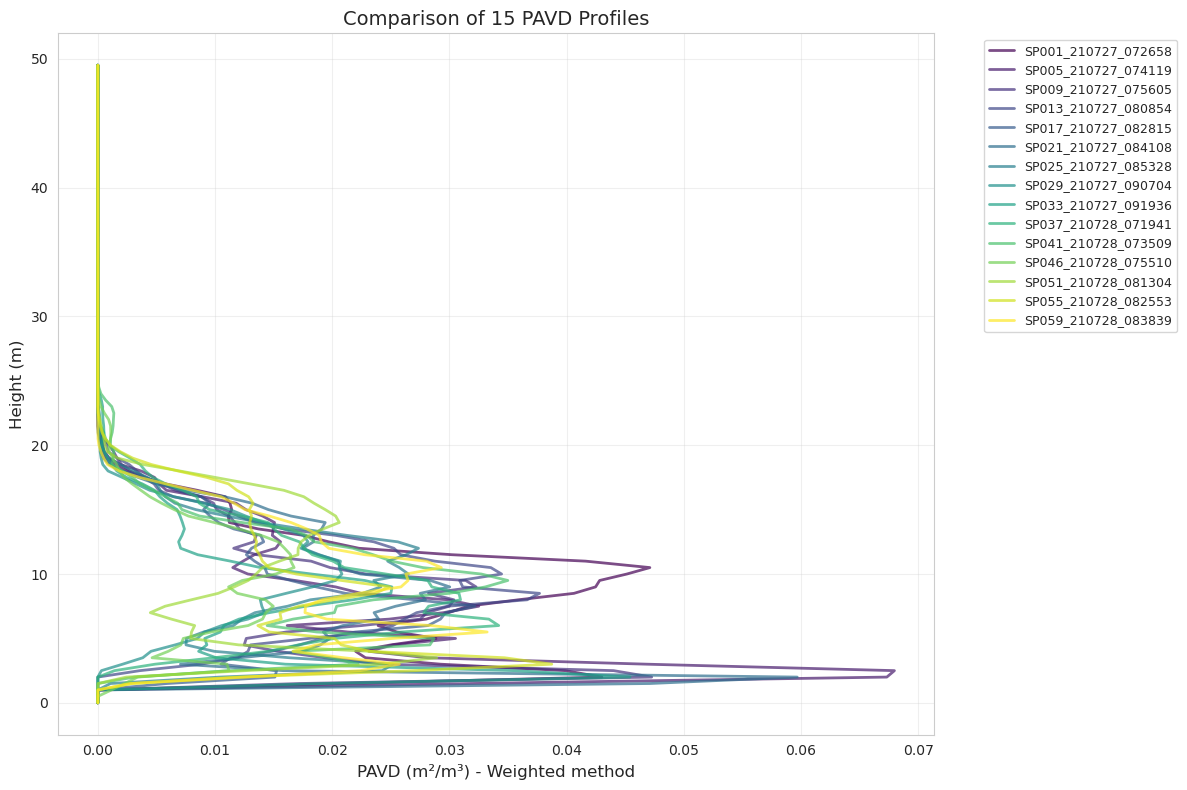

In [10]:
# Compare PAVD profiles across multiple scan positions
def plot_multiple_pavd_profiles(n_profiles=10, method='weighted'):
    """Plot PAVD profiles for multiple scan positions."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Select scans to plot (evenly spaced)
    step = max(1, len(profile_files) // n_profiles)
    selected_files = profile_files[::step][:n_profiles]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(selected_files)))
    
    for i, pfile in enumerate(selected_files):
        df = pd.read_csv(pfile)
        scan_name = pfile.stem.replace('_profiles', '').replace('ScanPos', 'SP')
        col_name = f'{method}_pavd'
        
        ax.plot(df[col_name], df['height'], '-', 
               label=scan_name, linewidth=2, alpha=0.7, color=colors[i])
    
    ax.set_xlabel(f'PAVD (m²/m³) - {method.capitalize()} method', fontsize=12)
    ax.set_ylabel('Height (m)', fontsize=12)
    ax.set_title(f'Comparison of {len(selected_files)} PAVD Profiles', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_multiple_pavd_profiles(n_profiles=15, method='weighted')

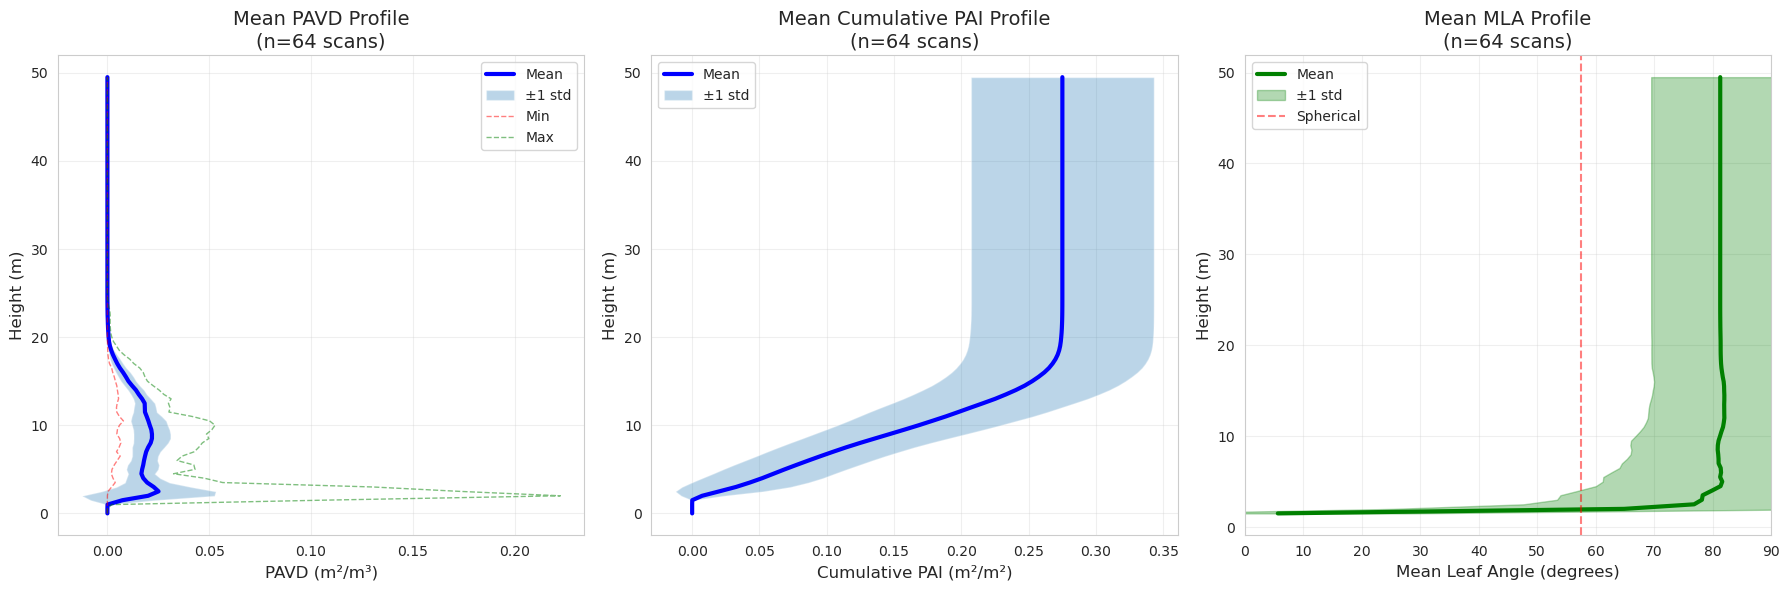

In [11]:
# Calculate and plot mean PAVD profile across all scans
def calculate_mean_profile():
    """Calculate mean and std of PAVD profiles across all scans."""
    all_profiles = []
    
    for pfile in profile_files:
        df = pd.read_csv(pfile)
        all_profiles.append(df)
    
    # Concatenate all profiles
    combined = pd.concat(all_profiles, keys=range(len(all_profiles)))
    
    # Group by height and calculate statistics
    stats = combined.groupby('height').agg({
        'weighted_pavd': ['mean', 'std', 'min', 'max'],
        'weighted_pai': ['mean', 'std'],
        'linear_mla': ['mean', 'std']
    }).reset_index()
    
    return stats

# Calculate statistics
mean_profile = calculate_mean_profile()

# Plot mean profile with confidence intervals
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mean PAVD with std
heights = mean_profile['height']
pavd_mean = mean_profile[('weighted_pavd', 'mean')]
pavd_std = mean_profile[('weighted_pavd', 'std')]
pavd_min = mean_profile[('weighted_pavd', 'min')]
pavd_max = mean_profile[('weighted_pavd', 'max')]

axes[0].plot(pavd_mean, heights, 'b-', linewidth=3, label='Mean')
axes[0].fill_betweenx(heights, pavd_mean - pavd_std, pavd_mean + pavd_std, 
                      alpha=0.3, label='±1 std')
axes[0].plot(pavd_min, heights, 'r--', alpha=0.5, linewidth=1, label='Min')
axes[0].plot(pavd_max, heights, 'g--', alpha=0.5, linewidth=1, label='Max')
axes[0].set_xlabel('PAVD (m²/m³)', fontsize=12)
axes[0].set_ylabel('Height (m)', fontsize=12)
axes[0].set_title(f'Mean PAVD Profile\n(n={len(profile_files)} scans)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Mean cumulative PAI
pai_mean = mean_profile[('weighted_pai', 'mean')]
pai_std = mean_profile[('weighted_pai', 'std')]

axes[1].plot(pai_mean, heights, 'b-', linewidth=3, label='Mean')
axes[1].fill_betweenx(heights, pai_mean - pai_std, pai_mean + pai_std, 
                      alpha=0.3, label='±1 std')
axes[1].set_xlabel('Cumulative PAI (m²/m²)', fontsize=12)
axes[1].set_ylabel('Height (m)', fontsize=12)
axes[1].set_title(f'Mean Cumulative PAI Profile\n(n={len(profile_files)} scans)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Mean MLA
mla_mean = mean_profile[('linear_mla', 'mean')]
mla_std = mean_profile[('linear_mla', 'std')]
# Filter out zeros
valid_mask = mla_mean > 0

axes[2].plot(mla_mean[valid_mask], heights[valid_mask], 'g-', linewidth=3, label='Mean')
axes[2].fill_betweenx(heights[valid_mask], 
                      mla_mean[valid_mask] - mla_std[valid_mask], 
                      mla_mean[valid_mask] + mla_std[valid_mask], 
                      alpha=0.3, label='±1 std', color='green')
axes[2].axvline(57.5, color='red', linestyle='--', alpha=0.5, label='Spherical')
axes[2].set_xlabel('Mean Leaf Angle (degrees)', fontsize=12)
axes[2].set_ylabel('Height (m)', fontsize=12)
axes[2].set_title(f'Mean MLA Profile\n(n={len(profile_files)} scans)', fontsize=14)
axes[2].set_xlim([0, 90])
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PAVD Heatmap Across All Scans

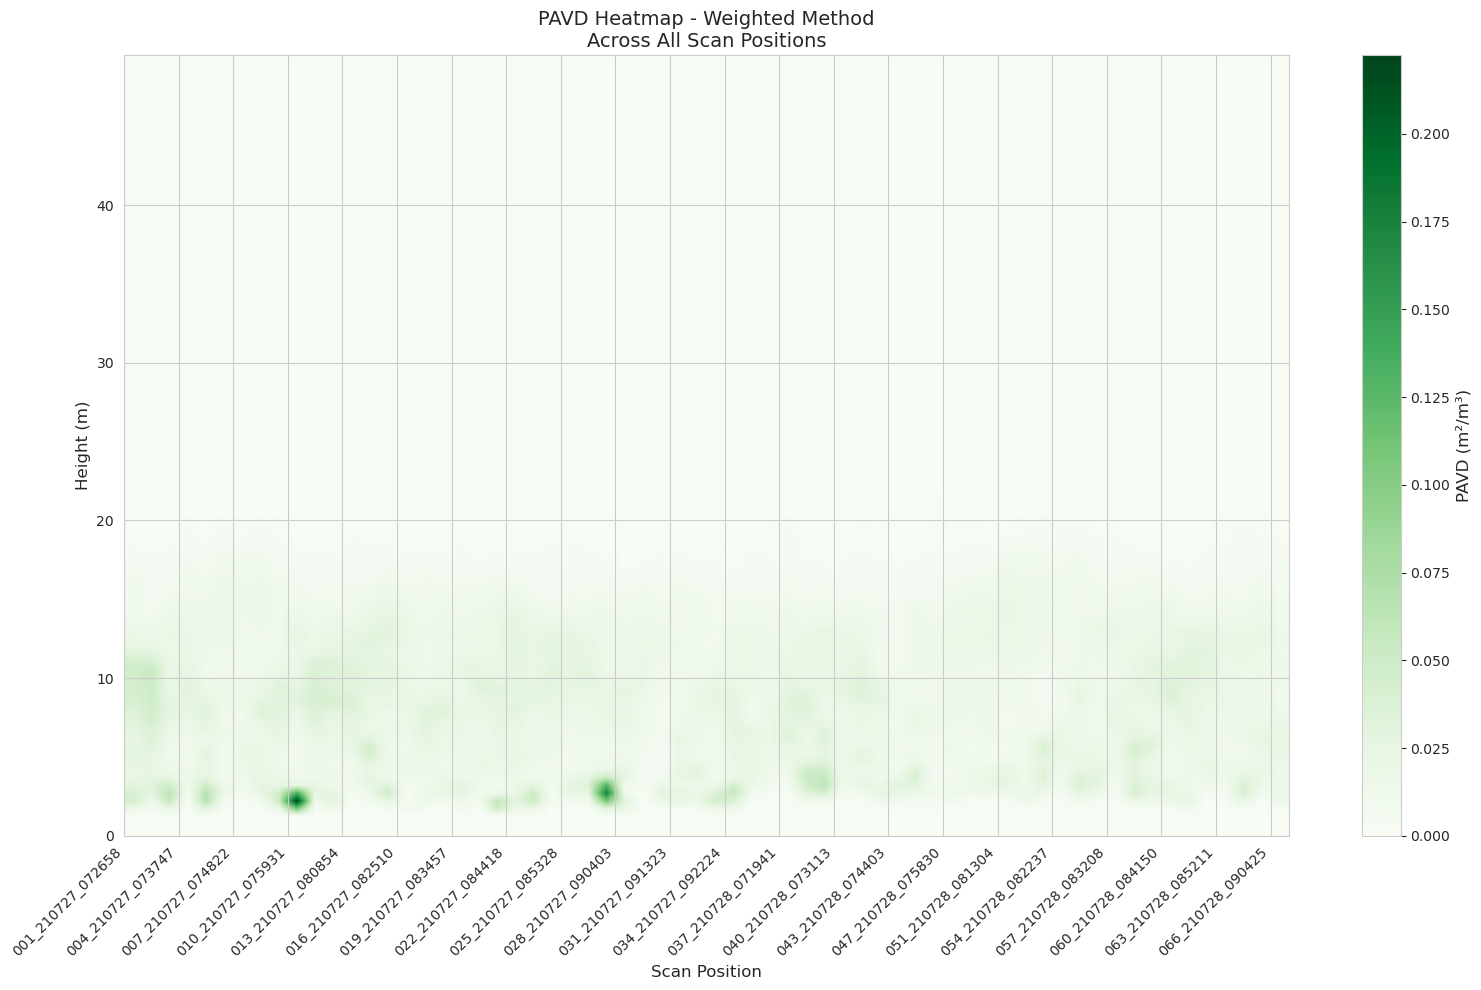

In [14]:
# Create heatmap of PAVD values across all scans and heights
def create_pavd_heatmap(method='weighted'):
    """Create a heatmap showing PAVD across all scans and heights."""
    
    # Collect all PAVD profiles
    pavd_matrix = []
    scan_names = []
    
    for pfile in sorted(profile_files):
        df = pd.read_csv(pfile)
        scan_name = pfile.stem.replace('_profiles', '').replace('ScanPos', '')
        scan_names.append(scan_name)
        pavd_matrix.append(df[f'{method}_pavd'].values)
    
    # Convert to array
    pavd_array = np.array(pavd_matrix)
    heights = df['height'].values
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(16, 10))
    
    im = ax.imshow(pavd_array.T, aspect='auto', cmap='Greens', 
                   extent=[0, len(scan_names), heights.min(), heights.max()],
                   origin='lower', interpolation='bilinear')
    
    ax.set_xlabel('Scan Position', fontsize=12)
    ax.set_ylabel('Height (m)', fontsize=12)
    ax.set_title(f'PAVD Heatmap - {method.capitalize()} Method\nAcross All Scan Positions', 
                fontsize=14)
    
    # Set x-ticks to show scan position numbers
    tick_positions = np.arange(0, len(scan_names), max(1, len(scan_names)//20))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([scan_names[i] for i in tick_positions], rotation=45, ha='right')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('PAVD (m²/m³)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

create_pavd_heatmap(method='weighted')

## Export Summary Statistics

In [13]:
# Print overall statistics
print("=" * 60)
print("OVERALL STATISTICS")
print("=" * 60)
print(f"\nTotal number of scans processed: {len(summary_df)}")
print(f"\nTotal PAI Statistics (Weighted Method):")
print(f"  Mean:   {summary_df['total_pai_weighted'].mean():.3f} m²/m²")
print(f"  Median: {summary_df['total_pai_weighted'].median():.3f} m²/m²")
print(f"  Std:    {summary_df['total_pai_weighted'].std():.3f} m²/m²")
print(f"  Min:    {summary_df['total_pai_weighted'].min():.3f} m²/m²")
print(f"  Max:    {summary_df['total_pai_weighted'].max():.3f} m²/m²")

print(f"\nMethod Comparison:")
print(f"  Hinge method mean PAI:   {summary_df['total_pai_hinge'].mean():.3f} m²/m²")
print(f"  Linear method mean PAI:  {summary_df['total_pai_linear'].mean():.3f} m²/m²")
print(f"  Weighted method mean PAI: {summary_df['total_pai_weighted'].mean():.3f} m²/m²")

print(f"\nSensor Position Range:")
print(f"  X: {summary_df['sensor_x'].min():.2f} to {summary_df['sensor_x'].max():.2f} m")
print(f"  Y: {summary_df['sensor_y'].min():.2f} to {summary_df['sensor_y'].max():.2f} m")
print(f"  Z: {summary_df['sensor_z'].min():.2f} to {summary_df['sensor_z'].max():.2f} m")

print(f"\nGround Plane Statistics:")
print(f"  Mean intercept: {summary_df['ground_intercept'].mean():.3f} m")
print(f"  Mean slope X:   {summary_df['ground_slope_x'].mean():.5f}")
print(f"  Mean slope Y:   {summary_df['ground_slope_y'].mean():.5f}")
print("=" * 60)

OVERALL STATISTICS

Total number of scans processed: 64

Total PAI Statistics (Weighted Method):
  Mean:   11.298 m²/m²
  Median: 10.635 m²/m²
  Std:    3.003 m²/m²
  Min:    6.220 m²/m²
  Max:    20.642 m²/m²

Method Comparison:
  Hinge method mean PAI:   11.303 m²/m²
  Linear method mean PAI:  10.103 m²/m²
  Weighted method mean PAI: 11.298 m²/m²

Sensor Position Range:
  X: -18.51 to 122.90 m
  Y: -122.78 to 20.85 m
  Z: -3.52 to 1.79 m

Ground Plane Statistics:
  Mean intercept: -2.555 m
  Mean slope X:   -0.00341
  Mean slope Y:   -0.00480
